In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Task 03: Building hand gesture recognition model using CNN

Importing necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Disable XLA
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Set logging level to avoid unnecessary warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Clear TensorFlow session
from tensorflow.keras import backend as K
K.clear_session()


In [6]:
dataset_path = "/kaggle/input/leapgestrecog/leapGestRecog"

In [7]:
os.listdir('/kaggle/input/leapgestrecog/leapGestRecog')

['07', '05', '06', '02', '04', '00', '08', '09', '03', '01']

Parameters

In [8]:
batch_size = 32
img_size = 224
num_classes = 10

Getting File paths and Labels

In [9]:
def get_file_paths_and_labels(base_path):
    file_paths = []
    labels = []
    gesture_folders = [
        '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
        '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
    ]
    label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}
    
    for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)
        if os.path.isdir(subject_path):
            for gesture in gesture_folders:
                gesture_path = os.path.join(subject_path, gesture)
                if os.path.isdir(gesture_path):
                    for img_file in os.listdir(gesture_path):
                        img_path = os.path.join(gesture_path, img_file)
                        file_paths.append(img_path)
                        labels.append(label_map[gesture])
    return file_paths, labels

Function to display images

In [10]:
def display_images(file_paths, labels, label_map):
    unique_labels = list(label_map.values())
    label_to_name = {v: k for k, v in label_map.items()}
    
    plt.figure(figsize=(20, 20))
    for idx, label in enumerate(unique_labels):
        label_paths = [file_paths[i] for i in range(len(labels)) if labels[i] == label][:5]
        for i, img_path in enumerate(label_paths):
            img = load_img(img_path, color_mode='grayscale', target_size=(img_size, img_size))
            img = img_to_array(img) / 255.0
            plt.subplot(len(unique_labels), 5, idx * 5 + i + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(label_to_name[label])
            plt.axis('off')
    plt.show()

In [11]:
file_paths, labels = get_file_paths_and_labels(dataset_path)

In [12]:
print(f"First 10 file paths: {file_paths[:10]}")
print(f"First 10 labels: {labels[:10]}")

First 10 file paths: ['/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0175.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0097.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0144.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0083.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0096.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0182.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0160.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0192.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0152.png', '/kaggle/input/leapgestrecog/leapGestRecog/07/01_palm/frame_07_01_0116.png']
First 10 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
if not file_paths or not labels:
    raise ValueError("No file paths or labels found. Please check the dataset path and structure.")

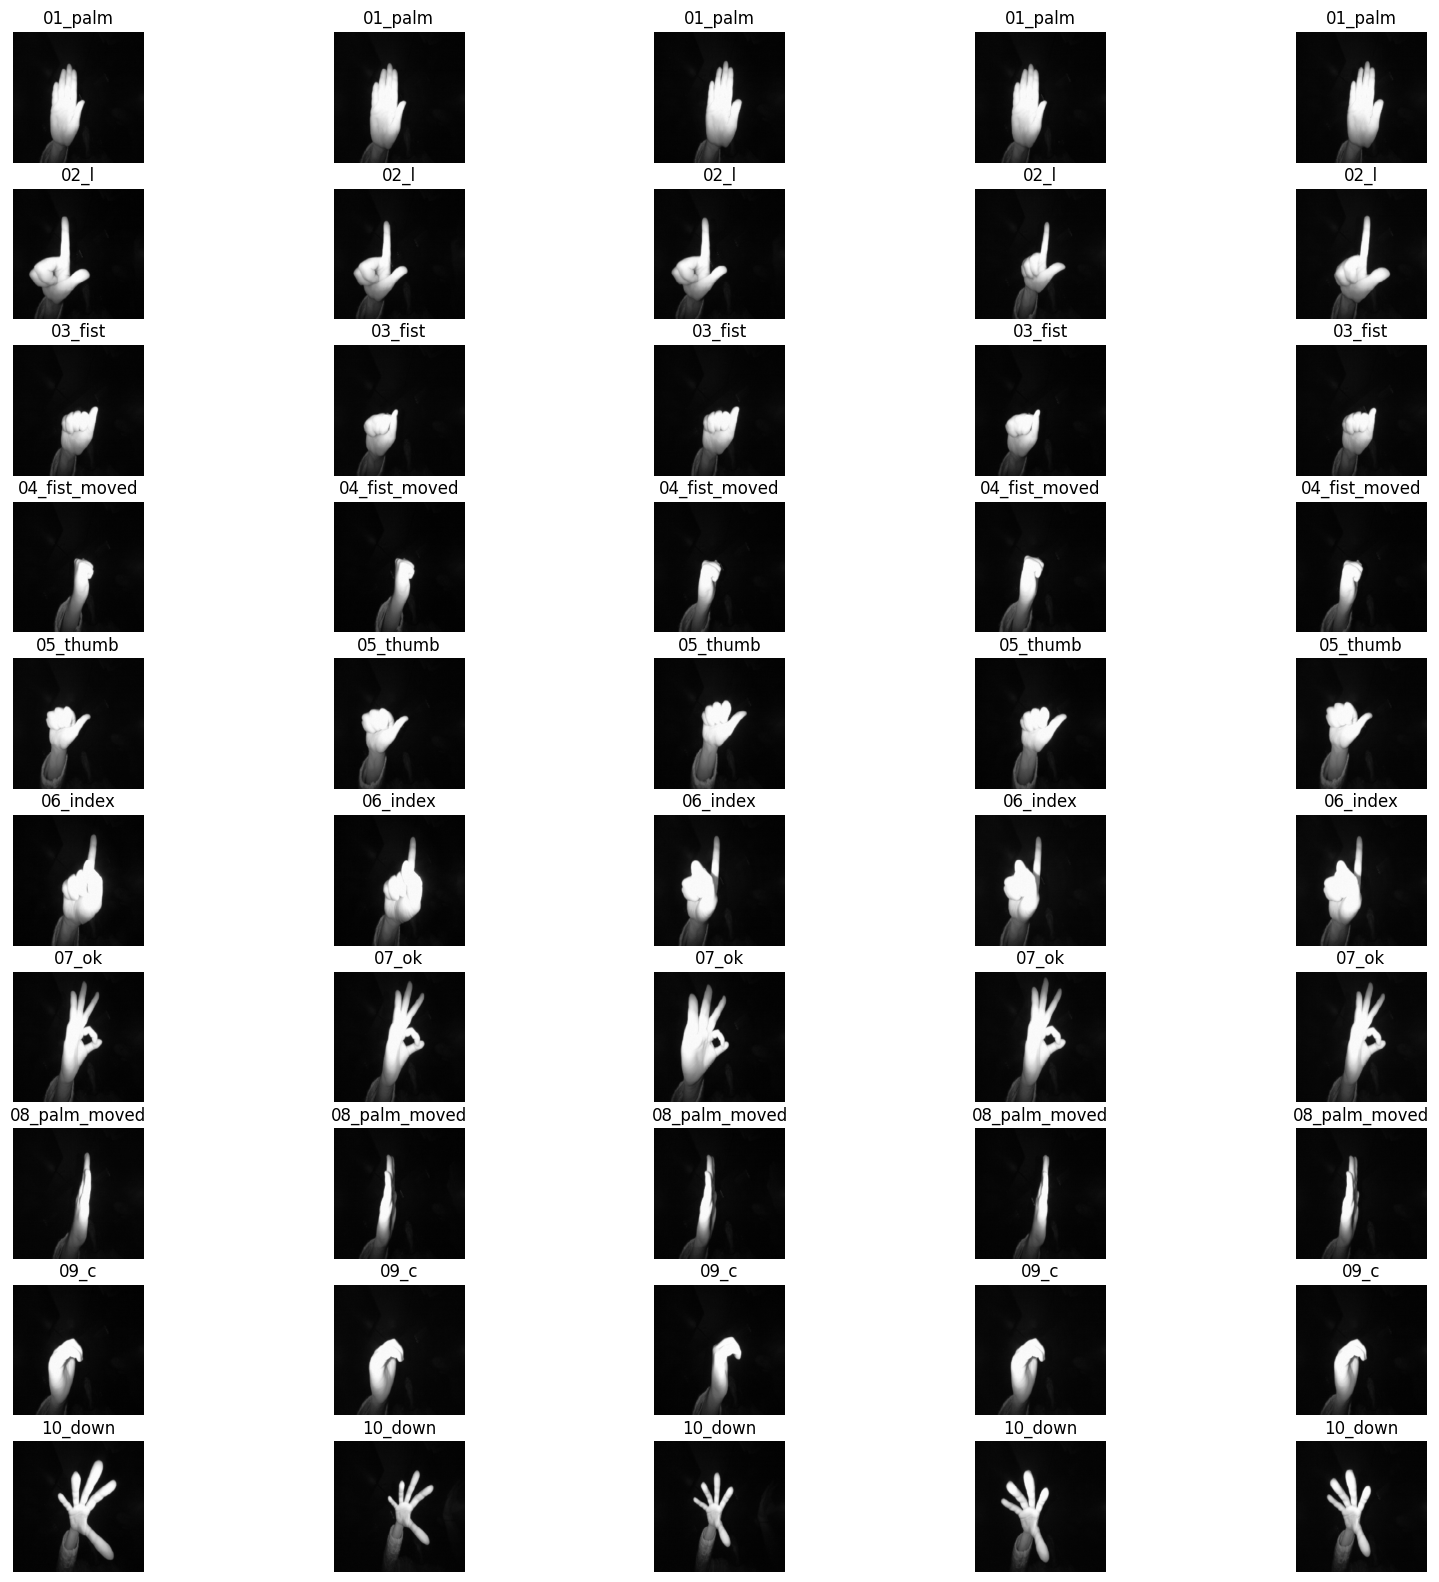

In [14]:
# Label map
gesture_folders = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', 
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]
label_map = {gesture: idx for idx, gesture in enumerate(gesture_folders)}

# Display the images
display_images(file_paths, labels, label_map)

In [15]:
data = list(zip(file_paths, labels))
np.random.shuffle(data)
file_paths, labels = zip(*data)

Converting labels to string

In [16]:
labels_str = [str(label) for label in labels]

Creating dataframe with file path and label

In [17]:
dataframe = pd.DataFrame({'filename': file_paths, 'class': labels_str})

ImageDataGenerator for traiining and validation

In [18]:
datagen = ImageDataGenerator(
    rescale=1/255.0,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2  # Reserve 20% of the data for validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe=dataframe,
    x_col='filename',
    y_col='class',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.


#### Defining CNN Model

In [19]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
Model Summary

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,401,226 (169.38 MB)

 Trainable params: 44,401,226 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

Compiling Model 

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

Training the model with Early Stopping

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1206s 2s/step - accuracy: 0.3242 - loss: 1.9093 - val_accuracy: 0.7893 - val_loss: 0.7321
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.7651 - loss: 0.7140 - val_accuracy: 0.9195 - val_loss: 0.2954
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1178s 2s/step - accuracy: 0.8600 - loss: 0.4203 - val_accuracy: 0.9482 - val_loss: 0.1834
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1177s 2s/step - accuracy: 0.9068 - loss: 0.2914 - val_accuracy: 0.9622 - val_loss: 0.1336
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.9295 - loss: 0.2208 - val_accuracy: 0.9715 - val_loss: 0.1040
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1181s 2s/step - accuracy: 0.9363 - loss: 0.1911 - val_accuracy: 0.9793 - val_loss: 0.0763
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.9521 - loss: 0.1433 - val_accuracy: 0.9808 - val_loss: 0.0680
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.9565 - loss: 0.1374 - 

Training history plot

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()



Model Evaluation

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

In [ ]:
model.save('hand_gesture_recognition_model.h5')

Image size and Gesture names

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
img_size = 224
gesture_classes = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', 
    '05_thumb', '06_index', '07_ok', '08_palm_moved', 
    '09_c', '10_down'
]

Model loading,Predicting gesture and displaying result

In [ ]:
def load_predict_and_display(img_path, model, img_size):
    # Load and preprocess the image (RGB)
    img = load_img(img_path, color_mode='rgb', target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
# Predict the gesture
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
# Display the image and the predicted class
    plt.imshow(img_array.squeeze(), cmap='gray') 
    plt.title(f'Predicted Gesture: {gesture_classes[predicted_class]}')
    plt.axis('off')
    plt.show()
    
# Load the trained model
loaded_model = load_model('hand_gesture_recognition_model.h5')

# Example image path (change this to any image you want to test)
test_img_path = '/kaggle/input/leapgestrecog/leapGestRecog/04/04_fist_moved/frame_04_04_0004.png'  # Replace with your image path
img_size = 224  # Ensure this matches the size used during training

# Predict and display the gesture
load_predict_and_display(test_img_path, loaded_model, img_size)

In [ ]:
test_img_path = '/kaggle/input/leapgestrecog/leapGestRecog/00/05_thumb/frame_00_05_0005.png'  # Replace with your image path
img_size = 224 

# Predict and display the gesture
load_predict_and_display(test_img_path, loaded_model, img_size)

In [ ]:
test_img_path = '/kaggle/input/leapgestrecog/leapGestRecog/00/01_palm/frame_00_01_0022.png'  # Replace with your image path
img_size = 224  # Ensure this matches the size used during training

# Predict and display the gesture
load_predict_and_display(test_img_path, loaded_model, img_size)